In [72]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import get_lagplot, autocorr_mat, compute_dRSA
from neural_utils.utils import load_monkey_data, load_stimuli_models, random_trials_per_rep, min_max_normalization, extract_fixation_responses_sing_trial, extract_fixation_responses_sing_stim 

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GroupKFold

In [3]:
monkey_name = "red"
month = 'aug'
day = 25
resolution_Hz = 100
npx = False
imec_n = 0
normalization = "min_max"
model_name = "dgIIE"
day = str(day)
neural_data, gaze_data = load_monkey_data(paths, monkey_name, day, month, resolution_Hz, npx=npx, imec_n=imec_n)
# normalizes them 
if normalization == "min_max":
    n_norm = min_max_normalization(neural_data)
# ADD zscore? robust?
elif normalization == None:
    n_norm = delete_empty_keys(neural_data)

# loads and upsamples the model 
all_models = load_stimuli_models(paths, model_name, n_norm.keys(), resolution_Hz)

# extract_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30)

In [ ]:
neural_data_fix, gaze_data_fix, model_data_fix = extract_fixation_responses_sing_stim(n_norm, gaze_data, all_models, list(n_norm.keys())[0], 10, 40, stack=1)
#neural_data_fix, gaze_data_fix, model_data_fix = random_trials_per_rep(n_norm, gaze_data, all_models,  100, trials_per_rep=2)

In [86]:
def multivariate_ou(T, dim, dt, corr_length, sigma=1.0):
    """
    T = total time duration
    dim = number of dimensions
    dt = time step
    corr_length = correlation length (tau)
    sigma = noise scale
    """
    N = int(T / dt)
    x = np.zeros((N, dim))

    alpha = dt / corr_length      # decay factor
    A = np.exp(-alpha)            # autocorrelation coefficient

    for t in range(1, N):
        noise = sigma * np.sqrt(1 - A**2) * np.random.randn(dim)
        x[t] = A * x[t-1] + noise

    return x

# Example:
tot_x = []
for i in range(10):
    x = multivariate_ou(T=10.0, dim=5, dt=0.1, corr_length=0.5)
    tot_x.append(x.T)
neural_data_fix = np.stack(tot_x, axis=-1)

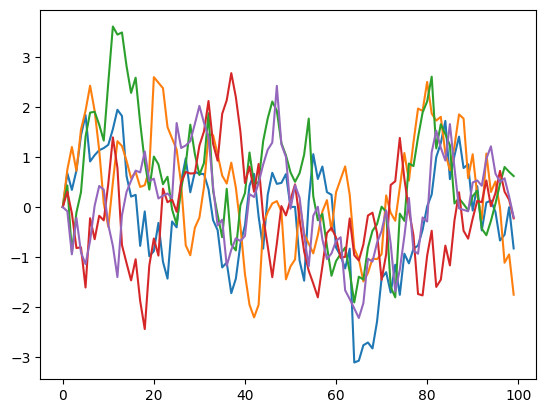

In [92]:
plt.plot(neural_data_fix[:,:,1].T)

In [87]:
# the other way would be to do all the timepoints at the same time and then play with the lag
# but how to treat different trials? 
lr_list = []
max_lag = 50

half_trials = int(neural_data_fix.shape[2]/2)
for L in range(-max_lag, max_lag):
    x_shifted_tot = []
    y_shifted_tot = []
    x_t_shifted_tot = []
    y_t_shifted_tot = [] 
    for i in range(half_trials):
        X = neural_data_fix[:,:,i].T
        y = neural_data_fix[:,:,i].T
        X_test = neural_data_fix[:,:,i].T
        y_test = neural_data_fix[:,:,i].T
        
        if L > 0:  # if positive lag
            x_shifted = X[:-L,:] # mod is shifted towards the right (so present neural is being compared with past model)
            y_shifted = y[L:,:]
            x_t_shifted = X_test[:-L,:]
            y_t_shifted = y_test[L:,:]
        elif L == 0:  # Handle L=0 case explicitly
            x_shifted = X
            y_shifted = y
            x_t_shifted = X_test
            y_t_shifted = y_test
        else:  # L < 0
            x_shifted = X[-L:,:] # mod is shifted towards the left (so present neural is being compared with future model)
            y_shifted = y[:L,:]
            x_t_shifted = X_test[-L:,:]
            y_t_shifted = y_test[:L,:]
        x_shifted_tot.append(x_shifted)
        y_shifted_tot.append(y_shifted)
        x_t_shifted_tot.append(x_t_shifted)
        y_t_shifted_tot.append(y_t_shifted)
       
    x_shifted_tot = np.concatenate(x_shifted_tot, axis=0)
    y_shifted_tot = np.concatenate(y_shifted_tot, axis=0)
    x_t_shifted_tot = np.concatenate(x_t_shifted_tot, axis=0)
    y_t_shifted_tot = np.concatenate(y_t_shifted_tot, axis=0)
    lr = LinearRegression().fit(x_shifted_tot, y_shifted_tot)
    lr_list.append(lr.score(x_t_shifted_tot, y_t_shifted_tot)) #x_t_shifted_tot, y_t_shifted_tot))

In [56]:
y_shifted_tot.shape

(4233, 20)

In [130]:
neural_data_fix = np.random.randn(20, 50, 100)
model_data_fix = 20*neural_data_fix +10

In [45]:
print(x_shifted_tot.shape)
print(x_t_shifted_tot.shape)

(2573, 20)
(2573, 20)


14:40:51 - There are nans in corr_mat
14:40:51 - There are nans in corr_mat
14:40:51 - There are nans in corr_mat


/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


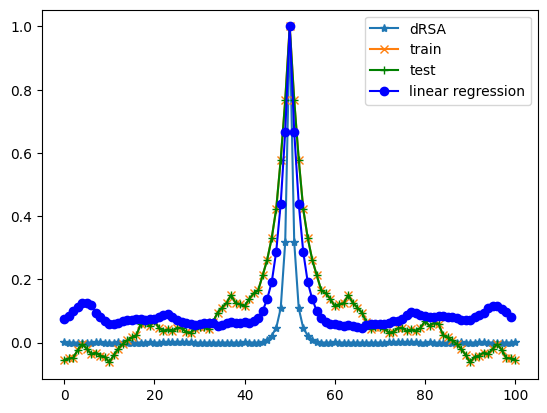

In [ ]:
# plt.plot(get_lagplot(compute_dRSA(neural_data_fix, neural_data_fix, metric_dRSA="correlation"), symmetric=True)[1:],marker="*")
# plt.plot(get_lagplot(autocorr_mat(x_shifted_tot.T), max_lag=50, symmetric=True)[1:], marker="x")
# plt.plot(get_lagplot(autocorr_mat(x_t_shifted_tot.T), max_lag=50, symmetric=True)[1:], marker="+", color="g")
# plt.plot(np.array(lr_list[1:]), marker="o", color="b")
# plt.legend(["dRSA", "train", "test", "linear regression"])
plt.plot(get_lagplot(compute_dRSA(neural_data_fix, neural_data_fix, metric_dRSA="correlation"), max_lag=50),marker="*")
plt.plot(get_lagplot(autocorr_mat(x_shifted_tot.T), max_lag=50), marker="x")
plt.plot(get_lagplot(autocorr_mat(x_t_shifted_tot.T), max_lag=50), marker="+", color="g")
plt.plot(np.array(lr_list), marker="o", color="b")
plt.legend(["dRSA", "train", "test", "linear regression"])